In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflowjs as tfjs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
columns = pd.read_csv('./data.csv', nrows=1).select_dtypes("number").columns
raw_dataset = pd.read_csv('./data.csv',usecols=columns, dtype=np.float32)
dataset = raw_dataset.copy()
print(raw_dataset.dtypes)

Follicles    float32
Eggs         float32
dtype: object


In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Follicles,1265.0,12.871937,7.833070,0.0,7.0,12.0,17.0,61.0
Eggs,1265.0,12.196838,7.493774,0.0,7.0,11.0,15.0,55.0


In [8]:
train_features = train_dataset.copy()
train_features.tail()
test_features = test_dataset.copy()
train_labels = train_features.pop('Eggs')
test_labels = test_features.pop('Eggs')

In [9]:
from numpy import float32
np.array(train_features, dtype=float32)
np.array(test_features, dtype=float32)

array([[11.],
       [ 7.],
       [14.],
       [ 9.],
       [18.],
       [24.],
       [ 4.],
       [ 8.],
       [ 4.],
       [16.],
       [ 8.],
       [ 6.],
       [11.],
       [11.],
       [ 8.],
       [18.],
       [17.],
       [ 6.],
       [16.],
       [ 8.],
       [14.],
       [ 8.],
       [14.],
       [ 6.],
       [ 2.],
       [ 4.],
       [10.],
       [ 5.],
       [22.],
       [ 5.],
       [22.],
       [ 8.],
       [ 8.],
       [40.],
       [ 7.],
       [ 8.],
       [10.],
       [ 1.],
       [14.],
       [17.],
       [12.],
       [ 3.],
       [ 0.],
       [ 2.],
       [14.],
       [20.],
       [ 9.],
       [19.],
       [11.],
       [12.],
       [ 3.],
       [ 7.],
       [13.],
       [ 8.],
       [ 3.],
       [ 3.],
       [ 9.],
       [10.],
       [ 7.],
       [ 7.],
       [13.],
       [14.],
       [12.],
       [14.],
       [11.],
       [ 8.],
       [15.],
       [18.],
       [11.],
       [10.],
       [ 3.],
      

In [10]:
follicles = np.array(train_features['Follicles'], dtype=float32)

In [11]:
follicles_normalizer = layers.Normalization(input_shape=[1,], axis=None)
follicles_normalizer.adapt(follicles)

In [12]:
follicles_model = keras.Sequential([follicles_normalizer, layers.Dense(units=1,dtype=tf.float32)])
follicles_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [13]:
from numpy import dtype


follicles_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
    )

In [14]:
%%time
history = follicles_model.fit(
    train_features['Follicles'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 18 s
Wall time: 14.1 s


In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.313537,3.552677,95
96,3.312792,3.531220,96
97,3.323219,3.532616,97
98,3.322315,3.539199,98
99,3.311550,3.530574,99


In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Eggs]')
  plt.legend()
  plt.grid(True)

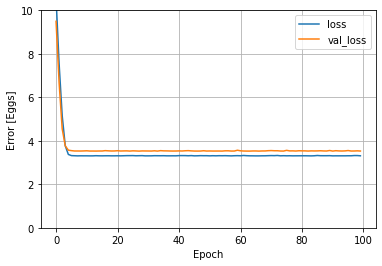

In [17]:
plot_loss(history)


In [18]:
test_results = {}

test_results['follicles_model'] = follicles_model.evaluate(
    test_features['Follicles'],
    test_labels, verbose=0)

In [19]:
x = tf.linspace(0.0, 80, 100)
y = follicles_model.predict(x)

4/4 [==============================] - 0s 3ms/step


In [20]:
def plot_result(x, y):
  plt.scatter(train_features['Follicles'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Follicles')
  plt.ylabel('Eggs')
  plt.legend()

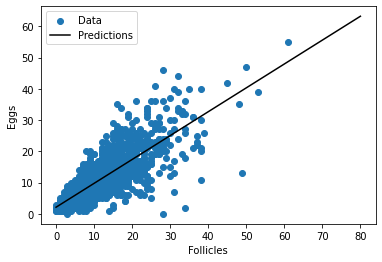

In [21]:
plot_result(x, y)


In [22]:
pd.DataFrame(test_results, index=['Mean absolute error [Eggs]'])


,follicles_model
Mean absolute error [Eggs],3.562767


10/10 [==============================] - 0s 2ms/step


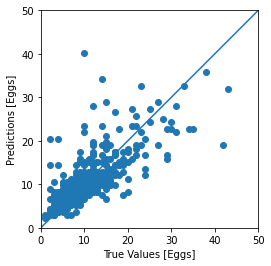

In [23]:
# print(np.array(test_features['Follicles']))
test_vals = np.array(test_features['Follicles'])
test_predictions = follicles_model.predict(test_vals)
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Eggs]')
plt.ylabel('Predictions [Eggs]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [24]:
tfjs.converters.save_keras_model(follicles_model, './eggPredictionModel')


weight count with shape () and dtype int64 was auto converted to the type int32


In [25]:
follicles_model.inputs[0].dtype


tf.float32

In [26]:
follicles_model.outputs[0].dtype

tf.float32

In [132]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu',dtype=tf.float32),
      layers.Dense(32, activation='relu',dtype=tf.float32),
      layers.Dense(1,dtype=tf.float32)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [133]:
dnn_follicle_model = build_and_compile_model(follicles_normalizer)


In [140]:
history = dnn_follicle_model.fit(
    train_features['Follicles'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

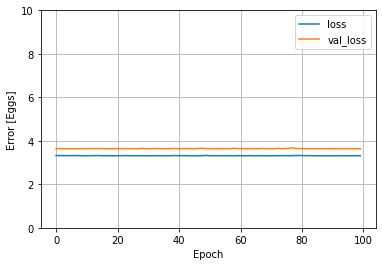

In [141]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


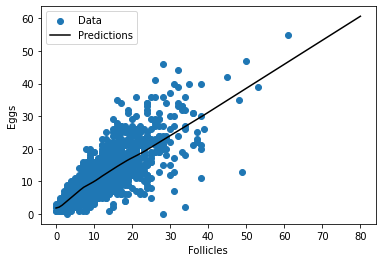

In [142]:
x = tf.linspace(0.0, 80, 100)
y = dnn_follicle_model.predict(x)
plot_result(x, y)


In [143]:
test_results['dnn_follicle_model'] = dnn_follicle_model.evaluate(
    test_features['Follicles'], test_labels,
    verbose=0)

10/10 [==============================] - 0s 1ms/step


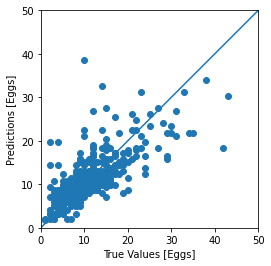

In [144]:
test_vals = np.array(test_features['Follicles'])
test_predictions = dnn_follicle_model.predict(test_vals)
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Eggs]')
plt.ylabel('Predictions [Eggs]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [145]:
pd.DataFrame(test_results, index=['Mean absolute error [Eggs]'])

,follicles_model,dnn_follicle_model
Mean absolute error [Eggs],3.562767,3.5249
